# SPAM Classifier using Scikit-Learn

NLP17 - http://www.cs.bgu.ac.il/~elhadad/nlp17.html

This notebook explains how to perform document classification using the Scikit-Learn and Pandas libraries.
Make sure to install the latest versions of these in your Anaconda environment with commands:

`# conda install scikit-learn`

`# conda install pandas`

We use a variety of vectorizers to turn text documents into feature vectors and compare different
classifier algorithms on these features.

The code is derived from notebooks published by Zac Stewart http://zacstewart.com/2015/04/28/document-classification-with-scikit-learn.html and Radim Rehurek http://radimrehurek.com/data_science_python/.

## Datasets

We will work on two datasets - one of email messages classified as spam and ham (ham = not spam, good messages); 
and one of SMS messages, classified as spam and ham as well.

The email spam messages are collected from:
* The ENRON email archive http://www.aueb.gr/users/ion/data/enron-spam/
* The Apache Spam Assassin dataset https://spamassassin.apache.org/publiccorpus/

To make the work simpler, the two datasets are put into a single zip file here http://www.cs.bgu.ac.il/~elhadad/nlp17/spam.zip (107MB, contains about 60K files).  Unzip this file in the folder data/spam under the home folder of this notebook.

The SMS dataset is from:
* https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection



## Loading data

In [1]:
%matplotlib inline
import os
import sys
import numpy
from pandas import DataFrame
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.cross_validation import KFold
from sklearn.metrics import confusion_matrix, f1_score

def progress(i, end_val, bar_length=50):
    '''
    Print a progress bar of the form: Percent: [#####      ]
    i is the current progress value expected in a range [0..end_val]
    bar_length is the width of the progress bar on the screen.
    '''
    percent = float(i) / end_val
    hashes = '#' * int(round(percent * bar_length))
    spaces = ' ' * (bar_length - len(hashes))
    sys.stdout.write("\rPercent: [{0}] {1}%".format(hashes + spaces, int(round(percent * 100))))
    sys.stdout.flush()

NEWLINE = '\n'

The email files are organized in folders each containing only ham or spam files.
The following code loads the whole dataset into a Pandas dataframe.

You should learn about Pandas by running the following notebooks:
* [Cooking with Pandas](http://jvns.ca/blog/2013/12/22/cooking-with-pandas/) by Julia Evans (2013) - 
  introduction to the Pandas Python library to manipulate data with aggregations and queries.  
  The updated Git repository is [Panda Cookbook](https://github.com/jvns/pandas-cookbook).
* [Analyzing a Twitter Dataset with Pandas](https://github.com/gdsaxton/PANDAS), by Gregory Saxton (2015).

In [2]:
HAM = 'ham'
SPAM = 'spam'

SOURCES = [
    ('data/spam/spam',        SPAM),
    ('data/spam/easy_ham',    HAM),
    ('data/spam/hard_ham',    HAM),
    ('data/spam/beck-s',      HAM),
    ('data/spam/farmer-d',    HAM),
    ('data/spam/kaminski-v',  HAM),
    ('data/spam/kitchen-l',   HAM),
    ('data/spam/lokay-m',     HAM),
    ('data/spam/williams-w3', HAM),
    ('data/spam/BG',          SPAM),
    ('data/spam/GP',          SPAM),
    ('data/spam/SH',          SPAM)
]

SKIP_FILES = {'cmds'}


def read_files(path):
    '''
    Generator of pairs (filename, filecontent)
    for all files below path whose name is not in SKIP_FILES.
    The content of the file is of the form:
        header....
        <emptyline>
        body...
    This skips the headers and returns body only.
    '''
    for root, dir_names, file_names in os.walk(path):
        for path in dir_names:
            read_files(os.path.join(root, path))
        for file_name in file_names:
            if file_name not in SKIP_FILES:
                file_path = os.path.join(root, file_name)
                if os.path.isfile(file_path):
                    past_header, lines = False, []
                    f = open(file_path, encoding="latin-1")
                    for line in f:
                        if past_header:
                            lines.append(line)
                        elif line == NEWLINE:
                            past_header = True
                    f.close()
                    content = NEWLINE.join(lines)
                    yield file_path, content


def build_data_frame(l, path, classification):
    rows = []
    index = []
    for i, (file_name, text) in enumerate(read_files(path)):
        if ((i+l) % 100 == 0):
            progress(i+l, 58910, 50)
        rows.append({'text': text, 'class': classification})
        index.append(file_name)
   
    data_frame = DataFrame(rows, index=index)
    return data_frame, len(rows)

def load_data():
    data = DataFrame({'text': [], 'class': []})
    l = 0
    for path, classification in SOURCES:
        data_frame, nrows = build_data_frame(l, path, classification)
        data = data.append(data_frame)
        l += nrows
    data = data.reindex(numpy.random.permutation(data.index))
    return data


In [3]:
# This should take about 2 minutes
data=load_data()

Percent: [##################################################] 100%

In [4]:
len(data)

58902

In [5]:
data.describe()

,class,text
count,58902,58902
unique,2,52928
top,spam,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 3.2//E..."
freq,35363,93


# Building a Vectorizer and Classifier SkLearn Pipeline

In [6]:
def build_pipeline():
    pipeline = Pipeline([
        ('count_vectorizer',   CountVectorizer(ngram_range=(1, 2))),
        ('classifier',         MultinomialNB())
    ])
    return pipeline

def train(data = None, n_folds = 6):
    if data is None:
        print("Loading data...")
        data = load_data()
        print("Data loaded")
    k_fold = KFold(n=len(data), n_folds = n_folds)
    pipeline = build_pipeline()
    scores = []
    confusion = numpy.array([[0, 0], [0, 0]])
    print("Training with %d folds" % n_folds)
    for i, (train_indices, test_indices) in enumerate(k_fold):
        train_text = data.iloc[train_indices]['text'].values
        train_y = data.iloc[train_indices]['class'].values.astype(str)

        test_text = data.iloc[test_indices]['text'].values
        test_y = data.iloc[test_indices]['class'].values.astype(str)

        print("Training for fold %d" % i)
        pipeline.fit(train_text, train_y)
        print("Testing for fold %d" % i)
        predictions = pipeline.predict(test_text)

        confusion += confusion_matrix(test_y, predictions)
        score = f1_score(test_y, predictions, pos_label=SPAM)
        scores.append(score)
        print("Score for %d: %2.2f" % (i, score))
        print("Confusion matrix for %d: " % i)
        print(confusion)

    print('Total emails classified:', len(data))
    print('Score:', sum(scores)/len(scores))
    print('Confusion matrix:')
    print(confusion)
    return pipeline


In [7]:
from sklearn.linear_model import LogisticRegression

def build_pipeline2():
    pipeline = Pipeline([
        ('count_vectorizer',   CountVectorizer(ngram_range=(1, 2))),
        ('classifier',         LogisticRegression())
    ])
    return pipeline

def train2(data = None, n_folds = 4):
    if data is None:
        print("Loading data...")
        data = load_data()
        print("Data loaded")
    k_fold = KFold(n=len(data), n_folds = n_folds)
    pipeline = build_pipeline2()
    scores = []
    confusion = numpy.array([[0, 0], [0, 0]])
    print("Training with %d folds" % n_folds)
    for i, (train_indices, test_indices) in enumerate(k_fold):
        train_text = data.iloc[train_indices]['text'].values
        train_y = data.iloc[train_indices]['class'].values.astype(str)
        test_text = data.iloc[test_indices]['text'].values
        test_y = data.iloc[test_indices]['class'].values.astype(str)
        
        print("Training for fold %d" % i)
        pipeline.fit(train_text, train_y)
        print("Testing for fold %d" % i)
        predictions = pipeline.predict(test_text)
        
        confusion += confusion_matrix(test_y, predictions)
        score = f1_score(test_y, predictions, pos_label=SPAM)
        scores.append(score)
        
        print("Score for %d: %2.2f" % (i, score))
        print("Confusion matrix for %d: " % i)
        print(confusion)

    print('Total emails classified:', len(data))
    print('Score:', sum(scores)/len(scores))
    print('Confusion matrix:')
    print(confusion)
    return pipeline
    confusion = confusion_matrix(test_y, predictions)
    score = f1_score(test_y, predictions, pos_label=SPAM)
    print("Score for %d: %2.2f" % (i, score))
    print("Confusion matrix for %d: " % i)
    print(confusion)
    print('Total emails classified:', len(test_text))
    return pipeline

In [8]:
# This trains the pipeline on our data (about 60K email messages)
# using count vectors over unigrams and bigrams and using N-folding with 6 folds.
# The training takes about 5 minutes for Multinomial Naive Bayes and about 30 minutes for Logistic Regression.
pipeline = train2(data)

Training with 4 folds
Training for fold 0
Testing for fold 0
Score for 0: 0.99
Confusion matrix for 0: 
[[5871   40]
 [ 142 8673]]
Training for fold 1
Testing for fold 1
Score for 1: 0.99
Confusion matrix for 1: 
[[11753    79]
 [  243 17377]]
Training for fold 2
Testing for fold 2
Score for 2: 0.98
Confusion matrix for 2: 
[[17628   130]
 [  475 25944]]
Training for fold 3
Testing for fold 3
Score for 3: 0.98
Confusion matrix for 3: 
[[23356   183]
 [  691 34672]]
Total emails classified: 58902
Score: 0.987553424687
Confusion matrix:
[[23356   183]
 [  691 34672]]


In [9]:
pipeline_nb = train(data)

Training with 6 folds
Training for fold 0
Testing for fold 0
Score for 0: 0.98
Confusion matrix for 0: 
[[3990   14]
 [ 226 5587]]
Training for fold 1
Testing for fold 1
Score for 1: 0.98
Confusion matrix for 1: 
[[ 7868    25]
 [  444 11297]]
Training for fold 2
Testing for fold 2
Score for 2: 0.98
Confusion matrix for 2: 
[[11789    42]
 [  677 16943]]
Training for fold 3
Testing for fold 3
Score for 3: 0.98
Confusion matrix for 3: 
[[15673    52]
 [  932 22611]]
Training for fold 4
Testing for fold 4
Score for 4: 0.98
Confusion matrix for 4: 
[[19597    69]
 [ 1170 28249]]
Training for fold 5
Testing for fold 5
Score for 5: 0.98
Confusion matrix for 5: 
[[23452    87]
 [ 1420 33943]]
Total emails classified: 58902
Score: 0.978284202932
Confusion matrix:
[[23452    87]
 [ 1420 33943]]


In [10]:
data.describe()

,class,text
count,58902,58902
unique,2,52928
top,spam,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 3.2//E..."
freq,35363,93


In [11]:
from pandas import value_counts
value_counts(data['class'])

spam    35363
ham     23539
Name: class, dtype: int64

## Explore distribution of text length

We add a new column to our dataframe to represent the length of the messages.

In [12]:
data['length'] = data['text'].map(lambda text: len(text))

Let us explore the distribution of the message lengths:

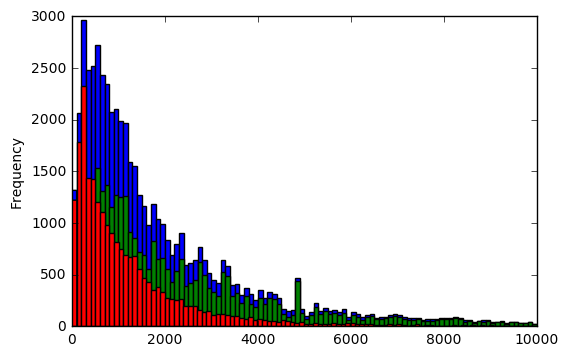

In [13]:

data.length[data.length < 10000].plot(bins=100, kind='hist')
dsl = data.length[(data['class'] == 'spam') & (data.length < 10000)]
dhl = data.length[(data['class'] == 'ham') & (data.length < 10000)]

dsl.plot(bins=100, kind='hist')
dhl.plot(bins=100, kind='hist')

In [14]:
data.groupby('class').describe()

length
class                     
ham   count   23539.000000
      mean     2136.225498
      std      7559.825825
      min         5.000000
      25%       342.000000
      50%       829.000000
      75%      1743.500000
      max    303302.000000
spam  count   35363.000000
      mean     4043.252467
      std      8418.154103
      min         0.000000
      25%       922.000000
      50%      1922.000000
      75%      4071.500000
      max    751895.000000

In [15]:
# All empty messages are marked as spam.
value_counts(data[data.length == 0]['class'])

spam    61
Name: class, dtype: int64

In [16]:
data[(data.length > 20) & (data.length < 10000)].groupby('class').describe()

length
class                    
ham   count  22842.000000
      mean    1270.940504
      std     1425.039593
      min       21.000000
      25%      333.000000
      50%      799.000000
      75%     1624.750000
      max     9960.000000
spam  count  32064.000000
      mean    2380.659930
      std     2064.126321
      min       24.000000
      25%      865.000000
      50%     1707.000000
      75%     3276.250000
      max     9999.000000